# Step 1: Setting up the dataset
The Image classification is uploaded as zip file and then extracted into a folder called dataset.

In [ ]:
!pip install split-folders

In [ ]:
data_path = '/content/Image_Classification.zip'

In [ ]:
import os
import zipfile

In [ ]:


dataset = 'dataset'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(dataset)



for root, dirs, files in os.walk(dataset):
    for file in files:
        print(os.path.join(root, file))

dataset/Image_Classification/dataset_14334027/Border_terrier/30.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/141.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/90.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/160.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/112.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/170.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/34.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/150.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/128.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/08.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/17.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/74.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/73.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/37.jpg
dataset/Image_Classification/dataset_14334

# Step 2: Importing Modules

In [ ]:
import os
import shutil
import random
from pathlib import Path
import zipfile

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import splitfolders as sf

# Step 3: Splitting the dataset

The dataset is split into train, validation and test sets using splitfolders into ratio of 70:15:15 respectively.

In [ ]:
input_folder = '/content/dataset/Image_Classification/dataset_14334027'

sf.ratio(input_folder, output="output",
    seed=14334027, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 3118 files [00:00, 8265.35 files/s]


In [ ]:
train_dir = "/content/output/train"
validation_dir = "/content/output/val"
test_dir = "/content/output/test"

# Step 4: Defining data generator and implementing data preprocessing

In this code, here, we have implemented data augmentation for the train dataset, and have rescaled the images for all 3 sets train, val and test.

The data augmentation done on the training dataset, is as follows:
*   rescale=1./255: Normalizes pixel values from [0, 255] to [0, 1].
*   rotation_range=40: Randomly rotate images up to 40 degrees.
*   width_shift_range / height_shift_range=0.2: Randomly shift the image horizontally/vertically by 20% of the width/height.
*   shear_range=0.2: Apply shear transformation.
*   zoom_range=0.2: Random zoom in/out.
*   horizontal_flip=True: Randomly flip the image horizontally.
*   fill_mode='nearest': Strategy to fill in new pixels created during transformations.


For the testing and validation data generator, only rescaling is applied; no augmentation since we want to evaluate performance on the real, unmodified data.







In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224) # We resize all images to a uniform dimension
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode='categorical' # the categorical class mode encodes labels as one-hot vectors for multi-class classification.
        )


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
       )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
)

Found 2174 images belonging to 20 classes.
Found 456 images belonging to 20 classes.
Found 488 images belonging to 20 classes.


# Step 5: Implementing Checkpointing and Earlystopping

Checkpointing: we save the best model according to the validation accuracy metric, we update the model every time we have better score.

Earlystopping: This will monitor the validation accuracy metric over 10 epcohs, if it does not improve we will stop training and restore the best weights.

In [ ]:
import math
from keras.optimizers import SGD, Adam, Adadelta
from keras.callbacks import LearningRateScheduler
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model

from IPython.display import HTML, display, clear_output, SVG

import warnings
warnings.filterwarnings("ignore")

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights= True,
    mode = 'max',
    verbose=1
)

# Step 6: Importing the model

Here, we import the ResNet50 model, except the topmost layer, we make sure that no layers are frozen, we also get the pre-defined weights for the imagenet dataset.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

resnetModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# In the above line, we also declare the input shape

x = resnetModel.output
x= GlobalAveragePooling2D()(x)
x = Dense(20, activation='softmax')(x)
#The above 2 lines basicall add the final dense layer.

resnetModel.trainable = True
#This is to make sure no layers are frozen

model = Model(inputs=resnetModel.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# The adam optimizer was a classic choice, it adjusts learning rates for better convergence.
#categorical crossentropy as this is a multiclassification problem

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# A good check on the model architecture

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,628,692 (90.14 MB)

 Trainable params: 23,575,572 (89.93 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
for layer in model.layers:
    print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

# Step 7: Training the model
The epochs are set to a modest 100.
Here the training stops early on epcoh 43.

In [ ]:
import matplotlib.pyplot as plt


history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint, earlystop],
    verbose=1
)




Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.4031 - loss: 2.2397
Epoch 1: val_accuracy improved from -inf to 0.05044, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4039 - loss: 2.2357 - val_accuracy: 0.0504 - val_loss: 1620.5750
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6735 - loss: 1.1423
Epoch 2: val_accuracy did not improve from 0.05044
68/68 ━━━━━━━━━━━━━━━━━━━━ 84s 520ms/step - accuracy: 0.6734 - loss: 1.1418 - val_accuracy: 0.0482 - val_loss: 97.7974
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.7295 - loss: 0.8445
Epoch 3: val_accuracy did not improve from 0.05044
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 516ms/step - accuracy: 0.7297 - loss: 0.8442 - val_accuracy: 0.0504 - val_loss: 3.1488
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7722 - loss: 0.7085
Epoch 4: val_accuracy improved from 0.05044 to 0.05482, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 0.7724 - loss: 0.7078 - val_accuracy: 0.0548 - val_loss: 5.7656
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8603 - loss: 0.4386
Epoch 5: val_accuracy did not improve from 0.05482
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 529ms/step - accuracy: 0.8599 - loss: 0.4393 - val_accuracy: 0.0504 - val_loss: 4.7165
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8463 - loss: 0.4965
Epoch 6: val_accuracy did not improve from 0.05482
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.8460 - loss: 0.4971 - val_accuracy: 0.0373 - val_loss: 4.5833
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8536 - loss: 0.4859
Epoch 7: val_accuracy improved from 0.05482 to 0.06798, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 556ms/step - accuracy: 0.8535 - loss: 0.4859 - val_accuracy: 0.0680 - val_loss: 4.2099
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8715 - loss: 0.3855
Epoch 8: val_accuracy did not improve from 0.06798
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.8715 - loss: 0.3855 - val_accuracy: 0.0526 - val_loss: 5.2449
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8835 - loss: 0.3647
Epoch 9: val_accuracy improved from 0.06798 to 0.08991, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 617ms/step - accuracy: 0.8834 - loss: 0.3649 - val_accuracy: 0.0899 - val_loss: 3.6104
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9057 - loss: 0.3178
Epoch 10: val_accuracy improved from 0.08991 to 0.10088, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 560ms/step - accuracy: 0.9054 - loss: 0.3182 - val_accuracy: 0.1009 - val_loss: 4.3556
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8923 - loss: 0.3175
Epoch 11: val_accuracy improved from 0.10088 to 0.20175, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 551ms/step - accuracy: 0.8924 - loss: 0.3176 - val_accuracy: 0.2018 - val_loss: 2.8909
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9330 - loss: 0.2265
Epoch 12: val_accuracy improved from 0.20175 to 0.42544, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 557ms/step - accuracy: 0.9327 - loss: 0.2270 - val_accuracy: 0.4254 - val_loss: 2.1154
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9146 - loss: 0.2778
Epoch 13: val_accuracy did not improve from 0.42544
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 536ms/step - accuracy: 0.9146 - loss: 0.2779 - val_accuracy: 0.3750 - val_loss: 2.0950
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9260 - loss: 0.2228
Epoch 14: val_accuracy improved from 0.42544 to 0.53070, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 610ms/step - accuracy: 0.9258 - loss: 0.2234 - val_accuracy: 0.5307 - val_loss: 2.0200
Epoch 15/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9127 - loss: 0.2711
Epoch 15: val_accuracy improved from 0.53070 to 0.67982, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.9127 - loss: 0.2709 - val_accuracy: 0.6798 - val_loss: 1.0933
Epoch 16/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9296 - loss: 0.2254
Epoch 16: val_accuracy did not improve from 0.67982
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 540ms/step - accuracy: 0.9296 - loss: 0.2254 - val_accuracy: 0.5789 - val_loss: 1.3285
Epoch 17/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9392 - loss: 0.2005
Epoch 17: val_accuracy improved from 0.67982 to 0.75219, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 591ms/step - accuracy: 0.9391 - loss: 0.2005 - val_accuracy: 0.7522 - val_loss: 0.8758
Epoch 18/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9318 - loss: 0.2042
Epoch 18: val_accuracy did not improve from 0.75219
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 535ms/step - accuracy: 0.9317 - loss: 0.2045 - val_accuracy: 0.7368 - val_loss: 0.9549
Epoch 19/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9370 - loss: 0.1772
Epoch 19: val_accuracy did not improve from 0.75219
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.9369 - loss: 0.1775 - val_accuracy: 0.7083 - val_loss: 1.0854
Epoch 20/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9532 - loss: 0.1502
Epoch 20: val_accuracy improved from 0.75219 to 0.76316, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 642ms/step - accuracy: 0.9531 - loss: 0.1506 - val_accuracy: 0.7632 - val_loss: 1.3219
Epoch 21/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9448 - loss: 0.1799
Epoch 21: val_accuracy did not improve from 0.76316
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.9446 - loss: 0.1804 - val_accuracy: 0.6601 - val_loss: 1.6897
Epoch 22/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9425 - loss: 0.1753
Epoch 22: val_accuracy did not improve from 0.76316
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step - accuracy: 0.9424 - loss: 0.1754 - val_accuracy: 0.6908 - val_loss: 1.2507
Epoch 23/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9404 - loss: 0.1703
Epoch 23: val_accuracy did not improve from 0.76316
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 535ms/step - accuracy: 0.9403 - loss: 0.1706 - val_accuracy: 0.6996 - val_loss: 1.1968
Epoch 24/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9297 - loss: 0.1818
Epoch 24: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 633ms/step - accuracy: 0.9701 - loss: 0.0973 - val_accuracy: 0.7719 - val_loss: 0.9421
Epoch 28/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9655 - loss: 0.1072
Epoch 28: val_accuracy did not improve from 0.77193
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 539ms/step - accuracy: 0.9654 - loss: 0.1074 - val_accuracy: 0.7610 - val_loss: 0.9925
Epoch 29/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9627 - loss: 0.1212
Epoch 29: val_accuracy did not improve from 0.77193
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step - accuracy: 0.9627 - loss: 0.1212 - val_accuracy: 0.6009 - val_loss: 2.8981
Epoch 30/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9385 - loss: 0.1846
Epoch 30: val_accuracy did not improve from 0.77193
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 569ms/step - accuracy: 0.9384 - loss: 0.1849 - val_accuracy: 0.5746 - val_loss: 2.0909
Epoch 31/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9554 - loss: 0.1352
Epoch 31: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 643ms/step - accuracy: 0.9554 - loss: 0.1352 - val_accuracy: 0.7785 - val_loss: 0.8350
Epoch 32/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9425 - loss: 0.1537
Epoch 32: val_accuracy did not improve from 0.77851
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 533ms/step - accuracy: 0.9425 - loss: 0.1538 - val_accuracy: 0.4737 - val_loss: 3.9378
Epoch 33/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9692 - loss: 0.1023
Epoch 33: val_accuracy improved from 0.77851 to 0.81579, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 639ms/step - accuracy: 0.9692 - loss: 0.1024 - val_accuracy: 0.8158 - val_loss: 0.8540
Epoch 34/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9668 - loss: 0.1061
Epoch 34: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step - accuracy: 0.9668 - loss: 0.1063 - val_accuracy: 0.4671 - val_loss: 3.0579
Epoch 35/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9679 - loss: 0.1023
Epoch 35: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 531ms/step - accuracy: 0.9679 - loss: 0.1023 - val_accuracy: 0.7215 - val_loss: 1.3675
Epoch 36/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9556 - loss: 0.1282
Epoch 36: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.9556 - loss: 0.1284 - val_accuracy: 0.7741 - val_loss: 1.0805
Epoch 37/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9655 - loss: 0.1083
Epoch 37: val_accura

# Step 8: Plotting the Accuracy and Loss curves

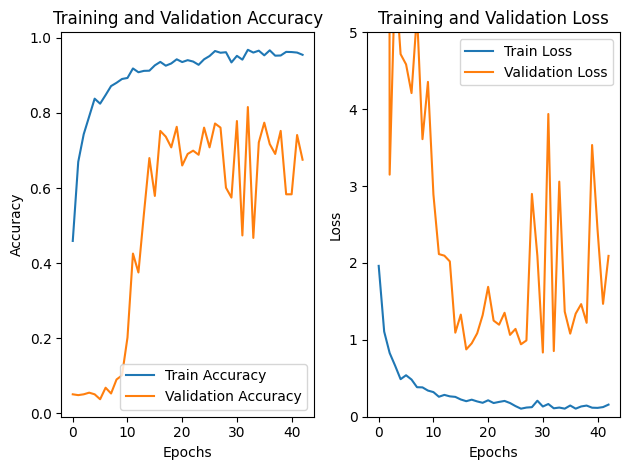

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.ylim(0, 5.0)

plt.tight_layout()
plt.show()

#Step 9: Resuming Training

I decided that my patience was set too low, and there was a possibility that the model could perform better over more epochs.
So I loaded the best model and did the training again.
The patience was increased to 20 and the epochs to 250, all other parameters were the same.

In [ ]:
from tensorflow.keras.models import load_model

newModel = load_model('best_model.h5')


In [ ]:
newModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
earlystop1 = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history = newModel.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=250,
    callbacks=[checkpoint, earlystop1],
    verbose=1
)


Epoch 1/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9433 - loss: 0.1967
Epoch 1: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 109s 864ms/step - accuracy: 0.9430 - loss: 0.1978 - val_accuracy: 0.4452 - val_loss: 4.4564
Epoch 2/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9299 - loss: 0.2142
Epoch 2: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.9300 - loss: 0.2140 - val_accuracy: 0.5614 - val_loss: 2.8951
Epoch 3/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9541 - loss: 0.1605
Epoch 3: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.9539 - loss: 0.1608 - val_accuracy: 0.5636 - val_loss: 2.1361
Epoch 4/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9458 - loss: 0.1577
Epoch 4: val_accuracy did not improve from 0.81579
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 533ms/step - accuracy: 0.9458 - loss: 0.1576 - val_accuracy: 0

68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 612ms/step - accuracy: 0.9836 - loss: 0.0521 - val_accuracy: 0.8224 - val_loss: 0.7392
Epoch 15/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9770 - loss: 0.0966
Epoch 15: val_accuracy did not improve from 0.82237
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 538ms/step - accuracy: 0.9770 - loss: 0.0964 - val_accuracy: 0.7632 - val_loss: 1.0564
Epoch 16/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9830 - loss: 0.0668
Epoch 16: val_accuracy did not improve from 0.82237
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 541ms/step - accuracy: 0.9830 - loss: 0.0669 - val_accuracy: 0.7873 - val_loss: 1.0079
Epoch 17/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9706 - loss: 0.0923
Epoch 17: val_accuracy did not improve from 0.82237
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 539ms/step - accuracy: 0.9706 - loss: 0.0923 - val_accuracy: 0.7675 - val_loss: 0.9797
Epoch 18/250
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9793 - loss: 0.0675
Epoch 18: val_accura

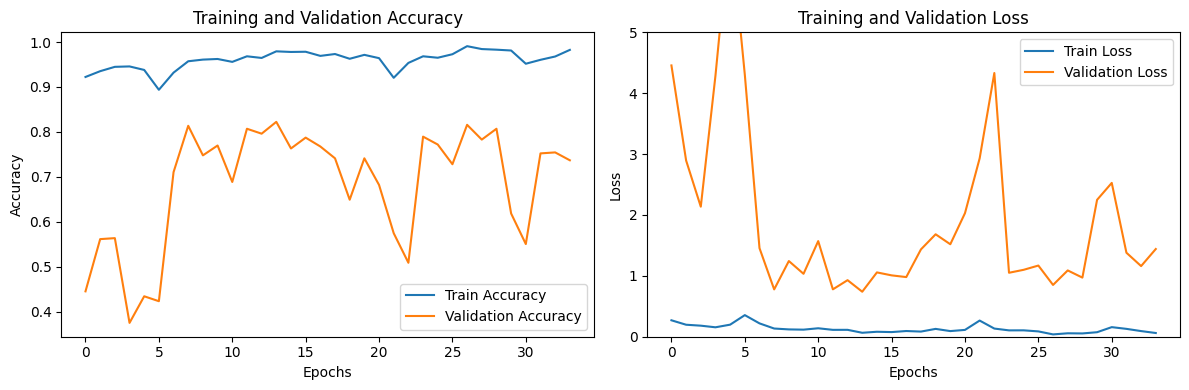

In [ ]:
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.ylim(0, 5.0)

plt.tight_layout()
plt.show()

#Step 10: Evaluating the model on the Test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8752 - loss: 0.5554
Test Accuracy: 84.43%
Test Loss: 0.6851


#Step 11: Evaluation Results
Here we get the classification report and the confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predictions = model.predict(test_generator, verbose=1)


predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_generator.classes


class_labels = list(test_generator.class_indices.keys())


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step


In [ ]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Classification Report:
                             precision    recall  f1-score   support

       AZURE BREASTED PITTA       1.00      1.00      1.00        23
        African_hunting_dog       0.81      0.81      0.81        26
                Appenzeller       0.81      0.88      0.84        24
        BORNEAN BRISTLEHEAD       1.00      0.83      0.91        24
             Border_terrier       0.76      0.93      0.83        27
                Boston_bull       0.81      0.79      0.80        28
          CARMINE BEE-EATER       0.93      1.00      0.96        25
                  CASSOWARY       0.76      1.00      0.86        25
            CHUCAO TAPACULO       0.96      0.96      0.96        23
                COMMON IORA       1.00      0.86      0.93        22
                   Cardigan       0.83      0.62      0.71        24
           English_springer       0.95      0.76      0.84        25
German_short-haired_pointer       0.72      0.75      0.73        24
          

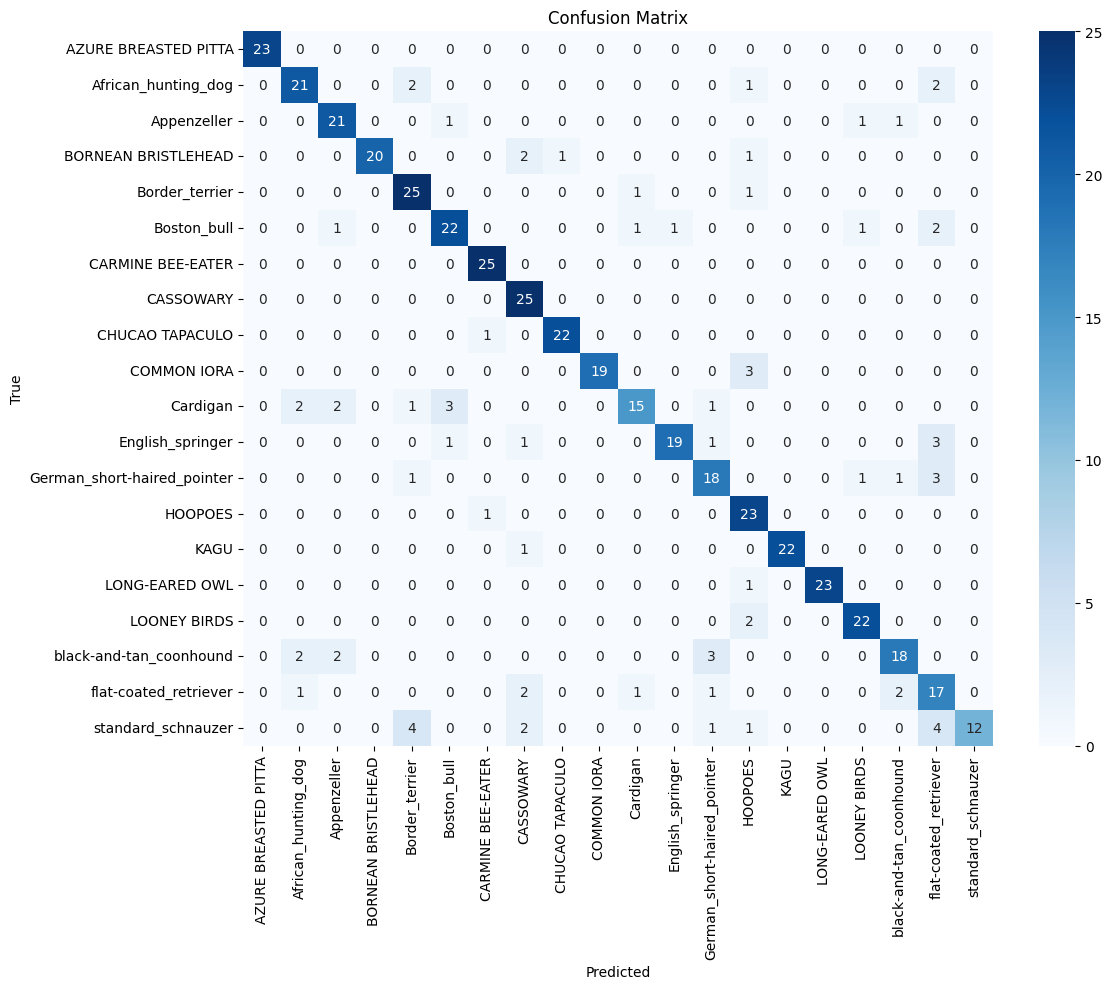

In [ ]:

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


#Step 12: Looking at some wrongly classifies images

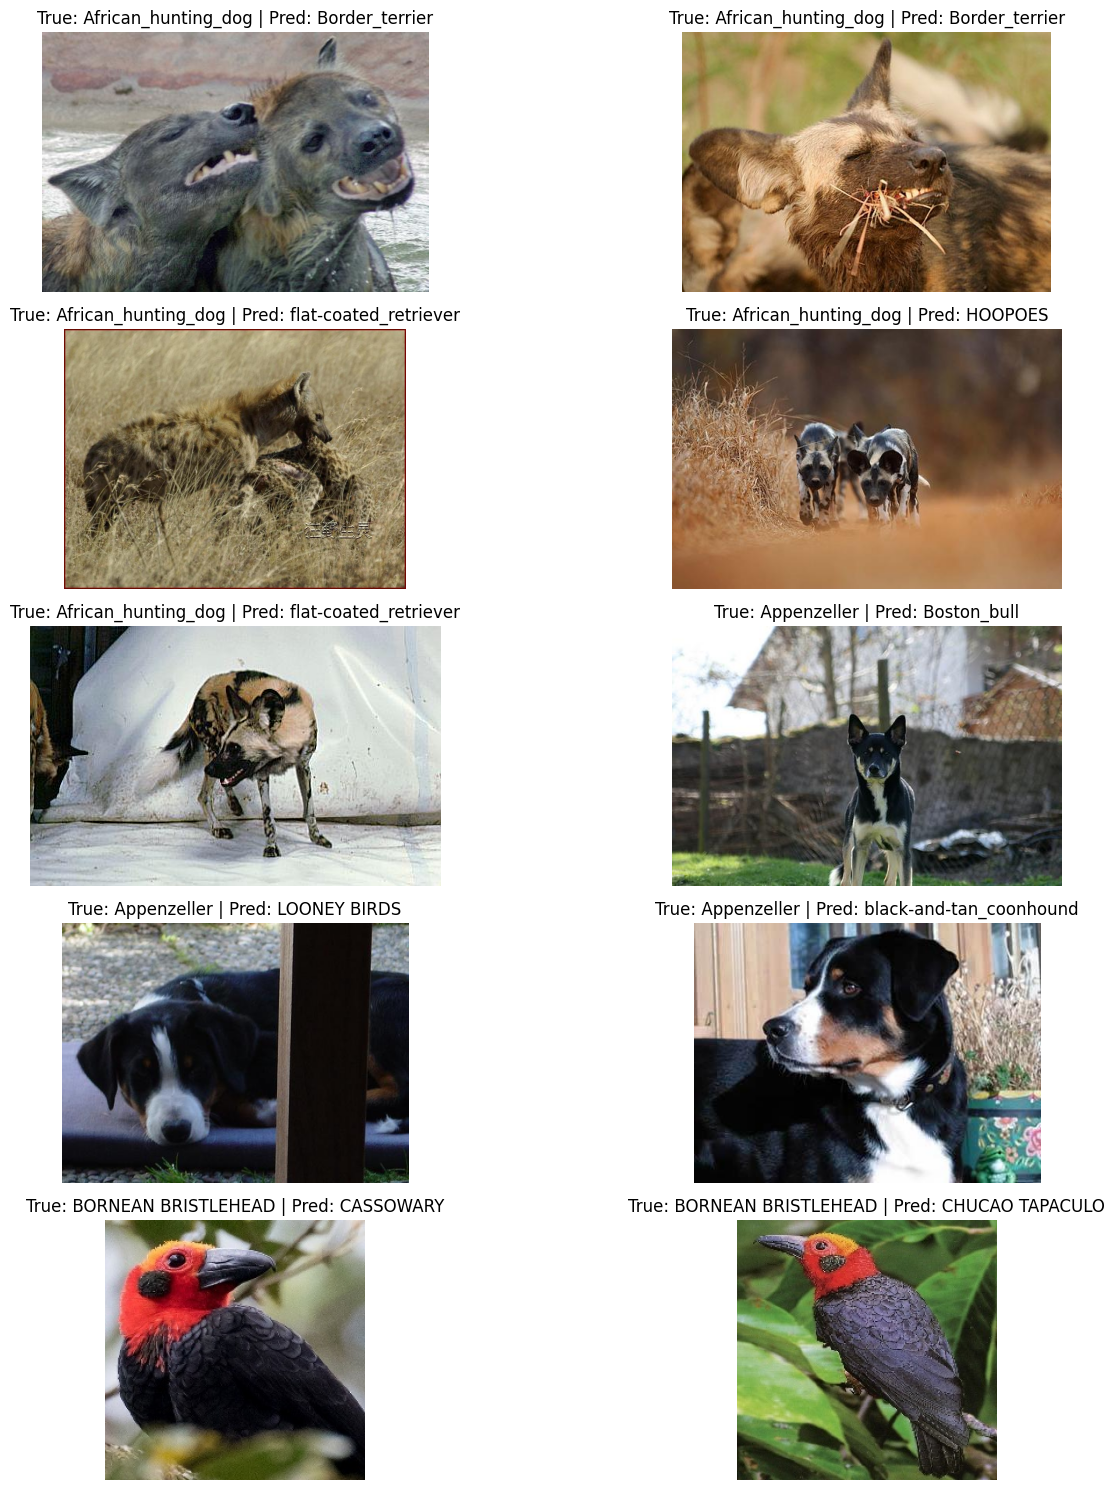

In [ ]:

filenames = test_generator.filenames

misclassified_indices = np.where(predicted_classes != true_classes)[0]


num_to_show = 10
plt.figure(figsize=(15, 15))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    img_path = filenames[idx]
    img = plt.imread(test_generator.directory + '/' + img_path)

    true_label = class_labels[true_classes[idx]]
    predicted_label = class_labels[predicted_classes[idx]]

    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

